# Testing Classifier performance on filtered signal

In [1]:
#import
import os 
import pandas as pd
import torch 
import IPython.display as ipd
import matplotlib.pyplot as plt
import random
import json
import re

#import modules
from model import BirdAudioClassifierModel
from utils import *
from classifier import BirdAudioClassifier

In [2]:
#define directories 
current_dir = os.getcwd() 
songs_path = os.path.join(current_dir, "Dataset\\audio_testing") #change

#load the metadata dataframe 
file_name = "Dataset\\birdsong_metadata.csv"
file_path = os.path.join(current_dir, file_name) 

df_birdsongs_metadata = pd.read_csv(file_path)
display(df_birdsongs_metadata)

print(df_birdsongs_metadata[df_birdsongs_metadata["file_id"] == 132608])

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/


   file_id     genus  species   english_cname who_provided_recording country  \
0   132608  Acanthis  flammea  Common Redpoll         Jarek Matusiak  Poland   

   latitude  longitute                type  \
0   50.7932    15.4995  female, male, song   

                                             license  
0  http://creativecommons.org/licenses/by-nc-sa/3.0/  


In [4]:
#Create the model
num_bird_classes = 88
model = BirdAudioClassifierModel(num_classes=num_bird_classes)
#load the trained model 
model.load_state_dict(torch.load('Models\model3.pth'))

<All keys matched successfully>

In [5]:
#Initialize the classifier
confidence_threshold = 0.1 #set the minimum confidence needed for a classification to be valid
BirdClassifier = BirdAudioClassifier(model=model, confidence_threshold=confidence_threshold)

In [6]:
#load the class id to name mapping
dict_file_path = "Dataset\\class_id_to_name_mapping.json"
with open(dict_file_path, "r") as file: 
    load_dict = json.load(file)
    #convert the keys to integers
    class_id_to_name_dict = {int(key): value for key, value in load_dict.items()}

print(class_id_to_name_dict)

{0: 'Long-tailed Tit', 1: 'Eurasian Golden Oriole', 2: 'Wood Warbler', 3: 'Lesser Whitethroat', 4: 'Common Starling', 5: 'Eurasian Collared Dove', 6: 'Common Reed Bunting', 7: 'Common Linnet', 8: 'Yellowhammer', 9: 'Western Yellow Wagtail', 10: 'Wood Sandpiper', 11: 'Garden Warbler', 12: 'Spotted Flycatcher', 13: 'Goldcrest', 14: 'Eurasian Wryneck', 15: 'Common Redshank', 16: 'River Warbler', 17: 'European Honey Buzzard', 18: 'Eurasian Bullfinch', 19: 'Rock Dove', 20: 'Dunlin', 21: 'African Pied Wagtail', 22: 'Sedge Warbler', 23: 'Eurasian Magpie', 24: 'Redwing', 25: 'Common Pheasant', 26: 'Common Chaffinch', 27: 'Willow Warbler', 28: 'Western Jackdaw', 29: 'Common Chiffchaff', 30: 'Great Tit', 31: 'Corn Bunting', 32: 'Eurasian Skylark', 33: 'Common Nightingale', 34: 'European Greenfinch', 35: 'Eurasian Reed Warbler', 36: 'European Herring Gull', 37: 'Eurasian Jay', 38: 'Common Blackbird', 39: 'Black-headed Gull', 40: 'Willow Ptarmigan', 41: 'Eurasian Treecreeper', 42: 'Black Woodpecke

In [7]:

file_list = os.listdir(songs_path)

#group the files with name
file_groups = {}
for file in file_list: 
    #extract identifier 
    identifier = file.split("_")[-1].split(".")[0]
    if identifier not in file_groups:
        file_groups[identifier] = []
    #add the file 
    file_groups[identifier].append(file)


#go through the file 
for identifier, group in file_groups.items(): 
    group = group[::-1]
    
    #lookup file name 
    bird_name = df_birdsongs_metadata[df_birdsongs_metadata["file_id"] == int(identifier[2:])]["english_cname"].iloc[0]
    print(f"Bird id: {identifier}, bird name: {bird_name}")

    #create the prediction for each file 
    for file in group: 
        print(f"File: {file}")
        #get the file path 
        audio_file_path = os.path.join(songs_path, file)

        #predict the class 
        pred_class, pred_confidence = BirdClassifier.predict_class_from_audio_file(file_path=audio_file_path)
        
        if pred_class is not None: 
            print(f"Predicted bird name: {class_id_to_name_dict[pred_class]}, confidence: {round(pred_confidence*100, 3)}%")
            # print("Actual bird name: Common Redpoll")
        else: 
            print("Could not identify a bird in the audio file")

    print("\n")

Bird id: xc101371, bird name: Long-tailed Tit
File: xc101371.flac
Predicted bird name: Long-tailed Tit, confidence: 100.0%
File: Medium_Wind_unfiltered_xc101371.wav
Predicted bird name: Long-tailed Tit, confidence: 100.0%
File: Medium_Wind_filtered_MW_xc101371.wav
Predicted bird name: Long-tailed Tit, confidence: 100.0%
File: Low_Wind_unfiltered_xc101371.wav
Predicted bird name: Long-tailed Tit, confidence: 100.0%
File: Low_Wind_filtered_LW_xc101371.wav
Predicted bird name: Long-tailed Tit, confidence: 100.0%
File: High_Wind_unfiltered_xc101371.wav
Predicted bird name: Long-tailed Tit, confidence: 92.9%
File: High_Wind_filtered_HW_xc101371.wav
Predicted bird name: Long-tailed Tit, confidence: 99.8%


Bird id: xc102932, bird name: Garden Warbler
File: xc102932.flac
Predicted bird name: Garden Warbler, confidence: 100.0%
File: Medium_Wind_unfiltered_xc102932.wav
Predicted bird name: Garden Warbler, confidence: 99.9%
File: Medium_Wind_filtered_MW_xc102932.wav
Predicted bird name: Garden W

Shape of spectrograms: torch.Size([1, 401, 2414])


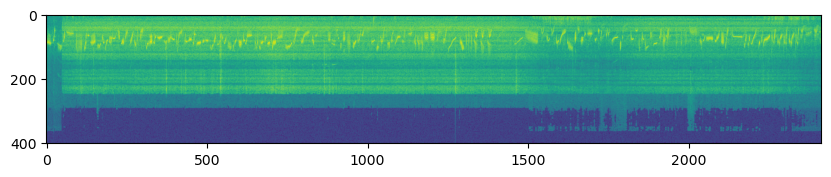

In [15]:
#spectrogram 
file = "High_Wind_unfiltered_xc116226.wav"
file = "High_Wind_filtered_HW_xc116226.wav"
file = "High_Wind_unfiltered_xc123169.wav"
file = "High_Wind_filtered_HW_xc123169.wav"
audio_file_path = os.path.join(songs_path, file)
#get the spectrogram 
waveform, sample_rate = AudioUtil.open_file(audio_file_path)        
spectrogram = AudioUtil.get_spectrogram(waveform)

#display the spectrogram
print(f"Shape of spectrograms: {spectrogram.size()}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram[0,:,:].numpy())

#make the sound wave available
ipd.Audio(waveform.numpy(), rate=sample_rate)